<a href="https://colab.research.google.com/github/baahujain/ML/blob/master/QuoraDuplicateQuestions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras.layers as layers
from keras.models import Model
from keras import backend as K
from google.colab import drive

Using TensorFlow backend.


In [2]:
#Mount in the google drive, in google the training data is placed
drive.mount('/content/drive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train.csv')


<BarContainer object of 2 artists>

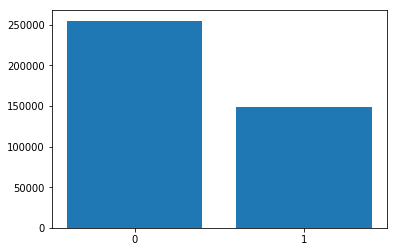

In [6]:

df.describe()
#remove entries which are blank
df = df.dropna(subset = ['question1', 'question2'])

#Check to see if there is any imbalance between duplicates and non-duplicates in training data
plt.bar(["0","1"],pd.value_counts(df.dropna()['is_duplicate']))


In [7]:


import tensorflow as tf
import tensorflow_hub as hub
url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"
embed = hub.Module(url)

#Get the sentence embedding (universal sentence encoder)
def GetEmbedding(x):
  return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]
  #return embed(x, signature="default", as_dict=True)["default"] 

W0605 11:57:32.571474 140582367655808 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


Instructions for updating:
Colocations handled automatically by placer.


W0605 11:57:33.713819 140582367655808 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Create a deep learning model. Here functional APIs are used. We have two input layers to take the 2 sentences. For every sentence we retrieve the sentence embedding.
The sentence embeddings are concatenated and passed thru 2 layers of dense layers. Last dense layer has a sigmoid activation to determine if the statements are duplicates or not.

In [9]:
DROP=0.1
q1=layers.Input(shape=(1,),dtype=tf.string)
embedding_q1 = layers.Lambda(GetEmbedding,output_shape=(512,))(q1)

q2=layers.Input(shape=(1,),dtype=tf.string)
embedding_q2 = layers.Lambda(GetEmbedding,output_shape=(512,))(q2)

x=layers.concatenate([embedding_q1,embedding_q2])
x=layers.Dense(200,activation='relu')(x)
x=layers.Dropout(0.1)(x)

x=layers.Dense(200,activation='relu')(x)
x=layers.Dropout(0.1)(x)

pred=layers.Dense(2,activation='sigmoid')(x)

model = Model(inputs=[q1,q2], outputs=pred)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0605 11:58:56.691562 140582367655808 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0605 11:58:57.890139 140582367655808 saver.py:1483] Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0605 11:58:58.084727 140582367655808 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512)          0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 512)          0           input_2[0][0]                    
__________________________________________________________________________________________________
concatenat

In [0]:
#Create traning and test data

from sklearn.model_selection import train_test_split
X1 = df['question1']
X2 = df['question2']
y = df['is_duplicate']
# Using the sklearn to split data in question1 and question2 train and test in the ration 80-20 %
X1_train, X1_test,X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size=0.2, random_state=42)

train_q1 = X1_train.tolist()
train_q1 = np.array(train_q1, dtype=object)#[:, np.newaxis]
train_q2 = X2_train.tolist()
train_q2 = np.array(train_q2, dtype=object)#[:, np.newaxis]

train_labels = np.asarray(pd.get_dummies(y_train[:]), dtype = np.int8)

test_q1 = X1_test.tolist()
test_q1 = np.array(test_q1, dtype=object)#[:, np.newaxis]
test_q2 = X2_test.tolist()
test_q2 = np.array(test_q2, dtype=object)#[:, np.newaxis]

test_labels = np.asarray(pd.get_dummies(y_test[:]), dtype = np.int8)

In [0]:
from keras.callbacks import ModelCheckpoint

# Training
with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  
  filepath="/content/drive/My Drive/Colab Notebooks/quoraDup/model-{epoch:02d}-{val_acc:.2f}.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=True, mode='auto', period=1)
  callbacks_list = [checkpoint]

  history = model.fit([train_q1, train_q2], 
            train_labels,
            validation_data=([test_q1, test_q2], test_labels),
            epochs=10,
            batch_size=512, callbacks=callbacks_list)

Train on 323429 samples, validate on 80858 samples
Epoch 1/10


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fdb4f62df60>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


323072/323429 [============================>.] - ETA: 0s - loss: 0.4472 - acc: 0.7788

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fdb4f4664a8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


323429/323429 [==============================] - 718s 2ms/step - loss: 0.4471 - acc: 0.7789 - val_loss: 0.3888 - val_acc: 0.8130
Epoch 2/10
323429/323429 [==============================] - 711s 2ms/step - loss: 0.3758 - acc: 0.8221 - val_loss: 0.3662 - val_acc: 0.8266
Epoch 3/10
323429/323429 [==============================] - 712s 2ms/step - loss: 0.3555 - acc: 0.8335 - val_loss: 0.3575 - val_acc: 0.8317
Epoch 4/10
323072/323429 [============================>.] - ETA: 0s - loss: 0.3422 - acc: 0.8417

In [0]:
import numpy as np
import tensorflow as tf
from keras import backend as K


# Predict the similarity of questions
with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  # Loading the save weights
  #Modify this to appropriate location
  model.load_weights('/content/drive/My Drive/Colab Notebooks/quoraDup/model-10-0.85.hdf5')  


  while 1:
  
    q1 = input("Key in your first question -->")
    q2 = input("Key in your second question -->") 
    q1 = np.array([[q1],[q1]])
    q2 = np.array([[q2],[q2]])
    predicts = model.predict([q1, q2], verbose=0)
    predict_logits = predicts.argmax(axis=1)
    print("----FINAL RESULT----")
    if(predict_logits[0] == 1):
      print("****Questions are Similar****")
    else:
      print("****Questions are not Similar****")